---

# Obesity Prediction using Machine Learning


---

This notebook is associated with Assignment 1. Use it to complete the assignment by following the instructions provided in each section, which includes a text cell describing the requirements. For additional details, see the Canvas.

In [21]:
# import libraries here

# Core data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# error handling
import warnings
warnings.filterwarnings("ignore")


# 1. **Data Management**


In this part, you need to:

1.   analyse and prepare the data. Use plots, graphs, and tables (such as histogram, box plots, scatterplots etc.) to better analyse the dataset and identify issues or potential improvements in the data, including (but not limited to) unnecessary feature/variable which can be dropped/removed, standardization, encoding, etc;
2.   split the data and define your experimental protocol (such as cross-validation or k-fold).

In [22]:
# Write your proposed solution code here. Create more code cells if you find it necessary

import pandas as pd
from pathlib import Path

#  File paths 
input_path = Path(r"C:\Users\hplap\Desktop\Applied AI\assignment1-dataset.csv")
output_path = Path(r"C:\Users\hplap\Desktop\Applied AI\assignment1-dataset-cleaned.csv")

# Load the dataset
df = pd.read_csv(input_path)

#Check how many duplicates exist
duplicates = df.duplicated().sum()
print(f" Found {duplicates} duplicate rows.")

# Remove duplicate rows (keep the first occurrence)
df_cleaned = df.drop_duplicates(keep="first")

# Save the cleaned data
df_cleaned.to_csv(output_path, index=False)
print(f" Cleaned file saved as:\n{output_path}")

# verify
print(f"Final row count: {len(df_cleaned)} (original: {len(df)})")


 Found 20 duplicate rows.
 Cleaned file saved as:
C:\Users\hplap\Desktop\Applied AI\assignment1-dataset-cleaned.csv
Final row count: 2091 (original: 2111)


In [23]:
# previewing cleaned datset
import pandas as pd
df = pd.read_csv(r"C:\Users\hplap\Desktop\Applied AI\assignment1-dataset-cleaned.csv")
df.head()


,Gender,Age,Height,Weight,family_overweight,HCF,VegMeals,Meals,FD,MealsBetw,SMOKE,WaterQ,CaloriesMonitor,PhysAct,TechUsage,AlcConsume,TransMeans,ObesityLvl
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,0.832932,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,1.056377,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,0.962160,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,0.908676,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,0.000000,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


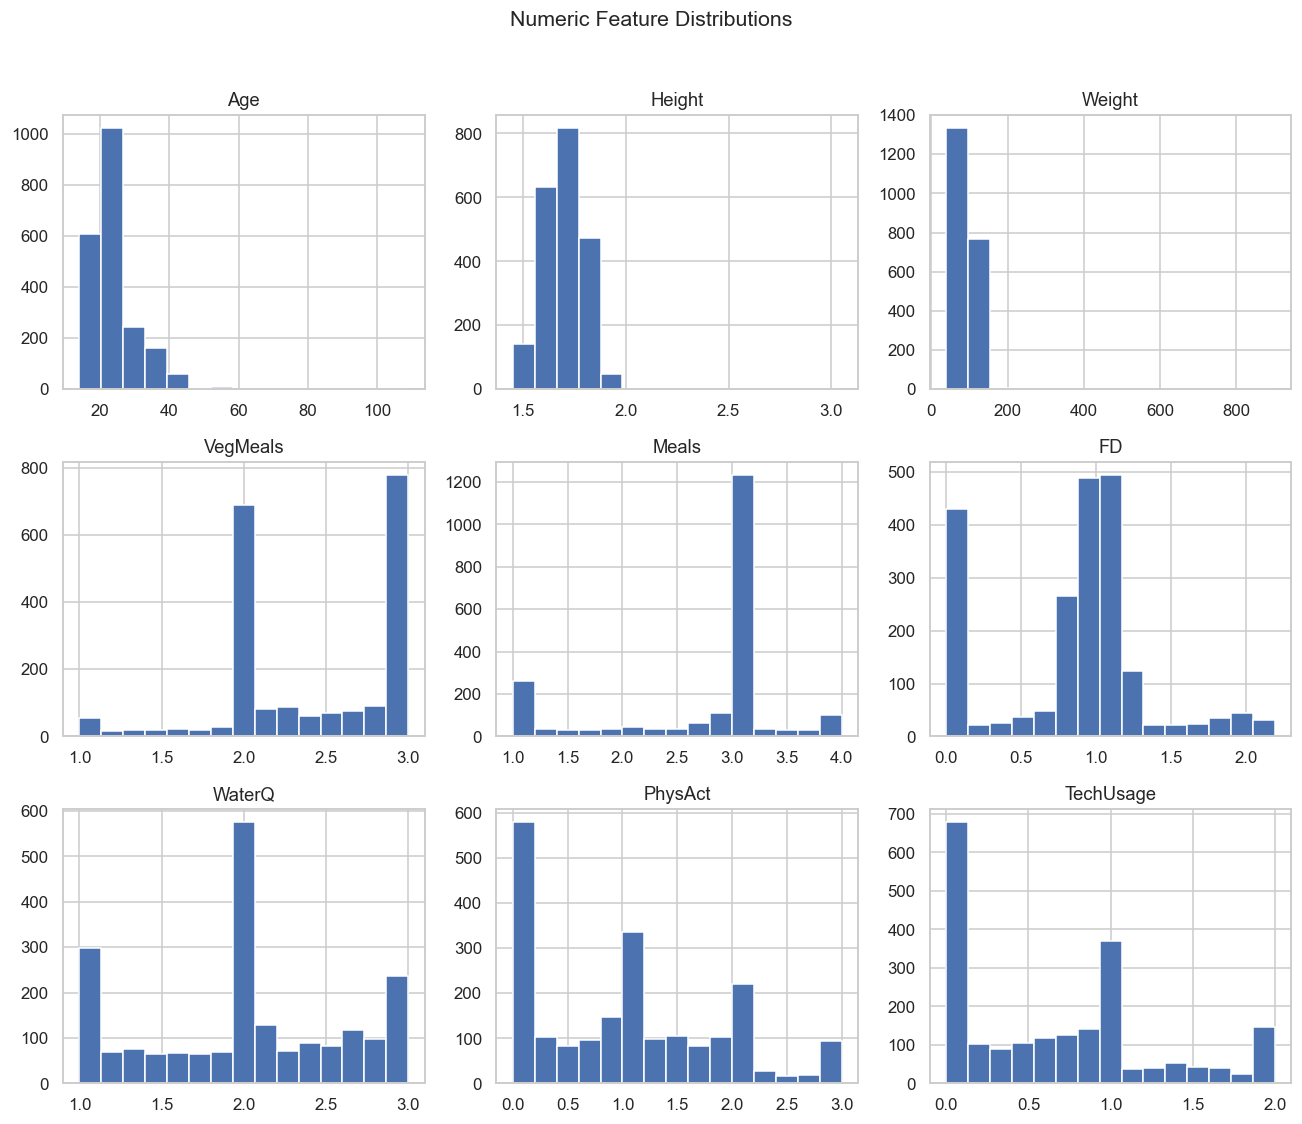

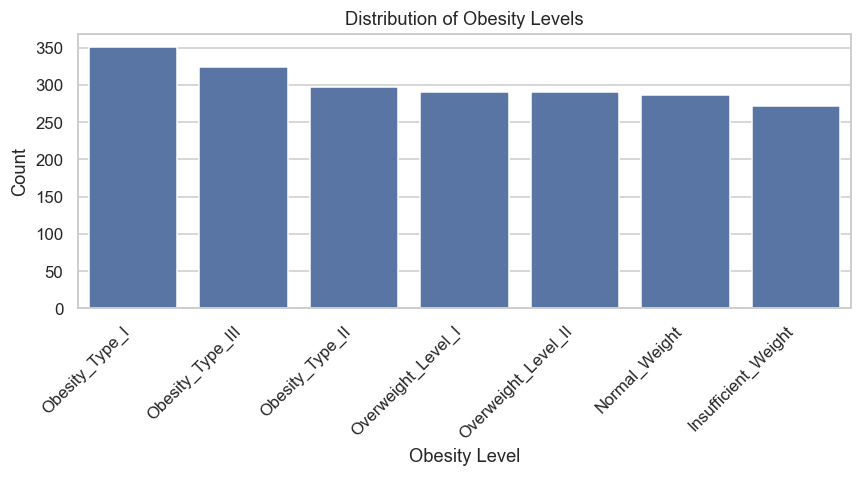

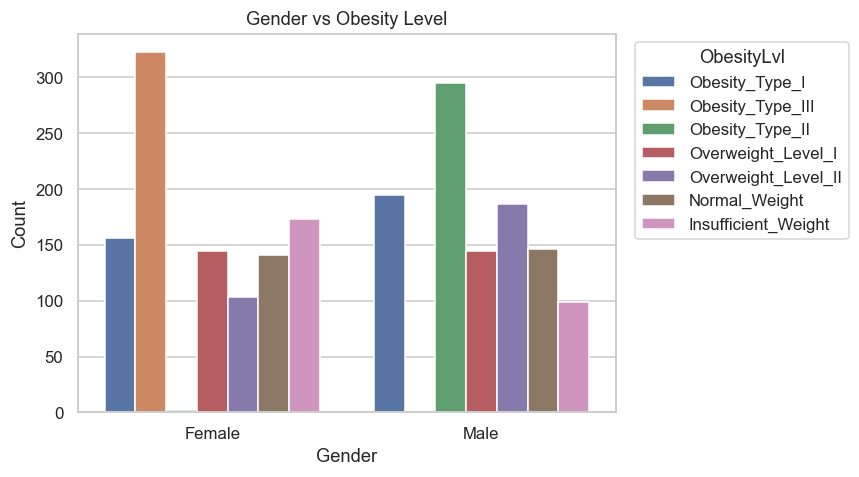

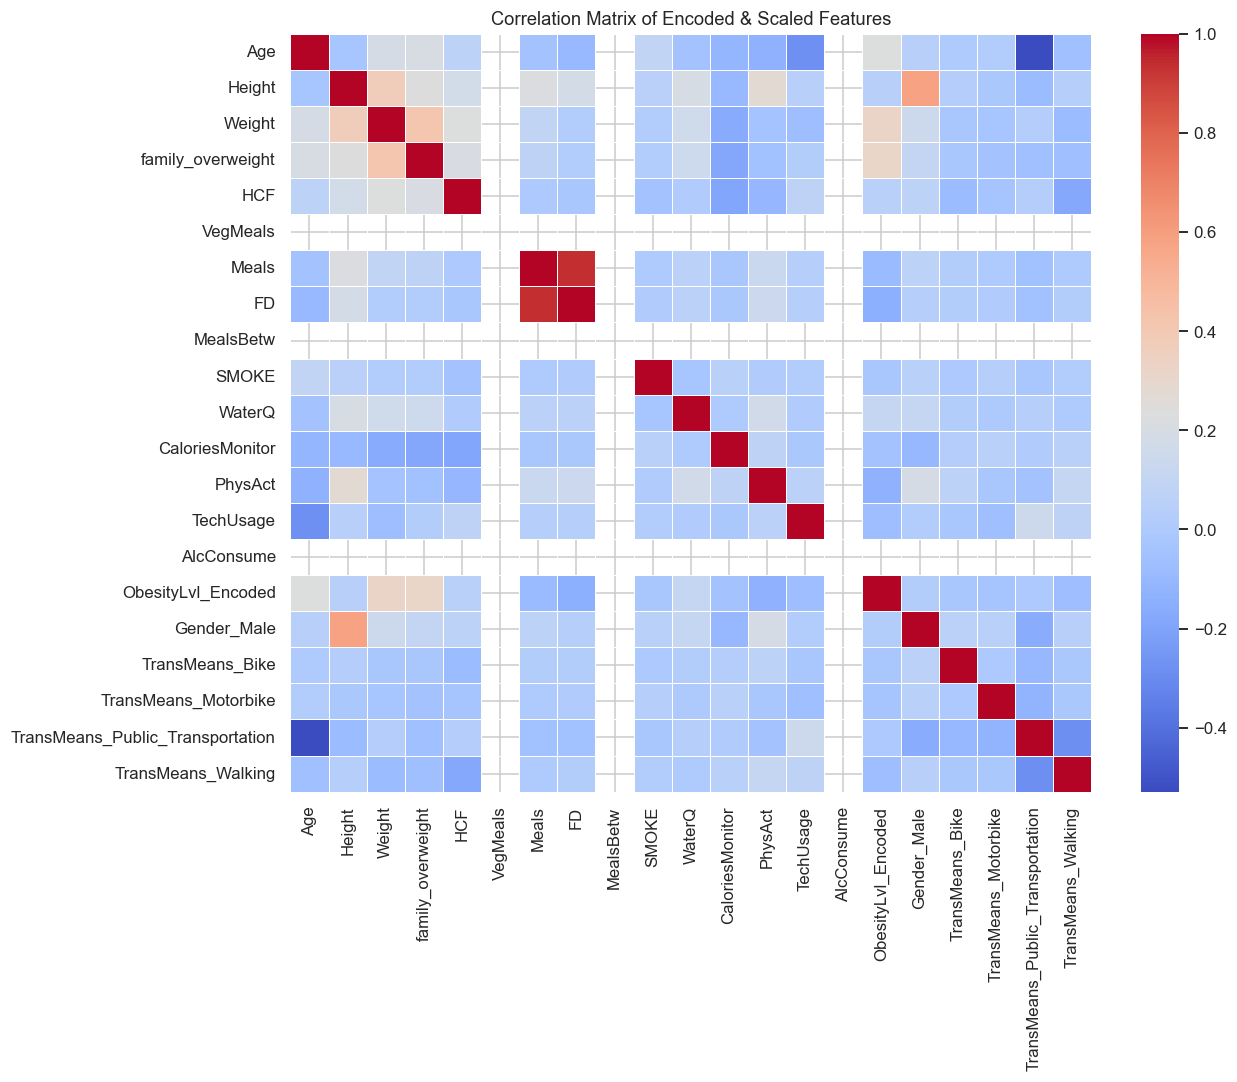

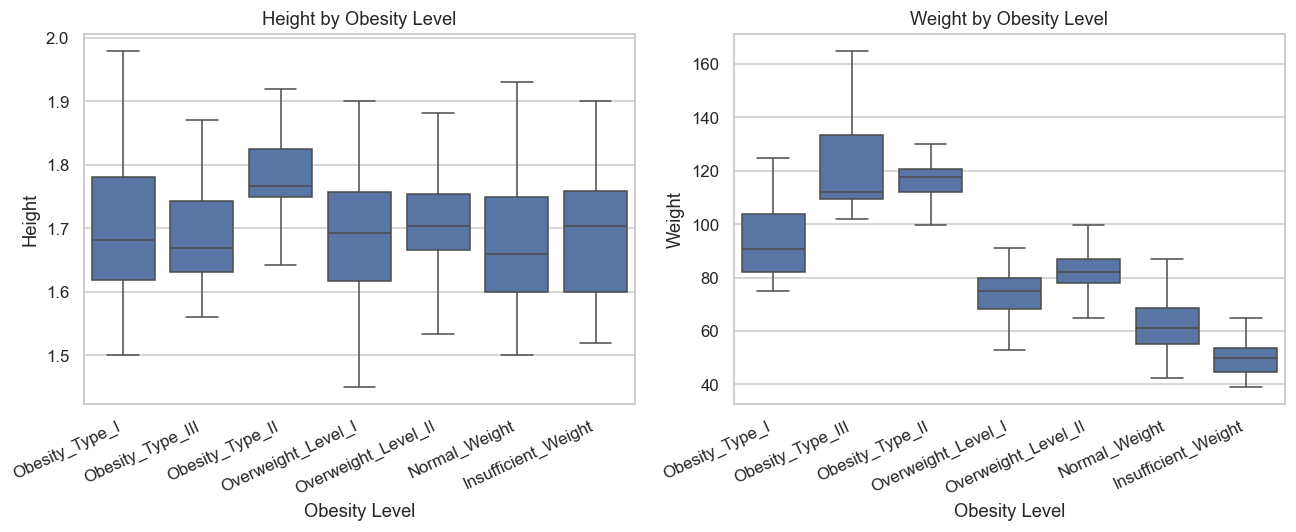

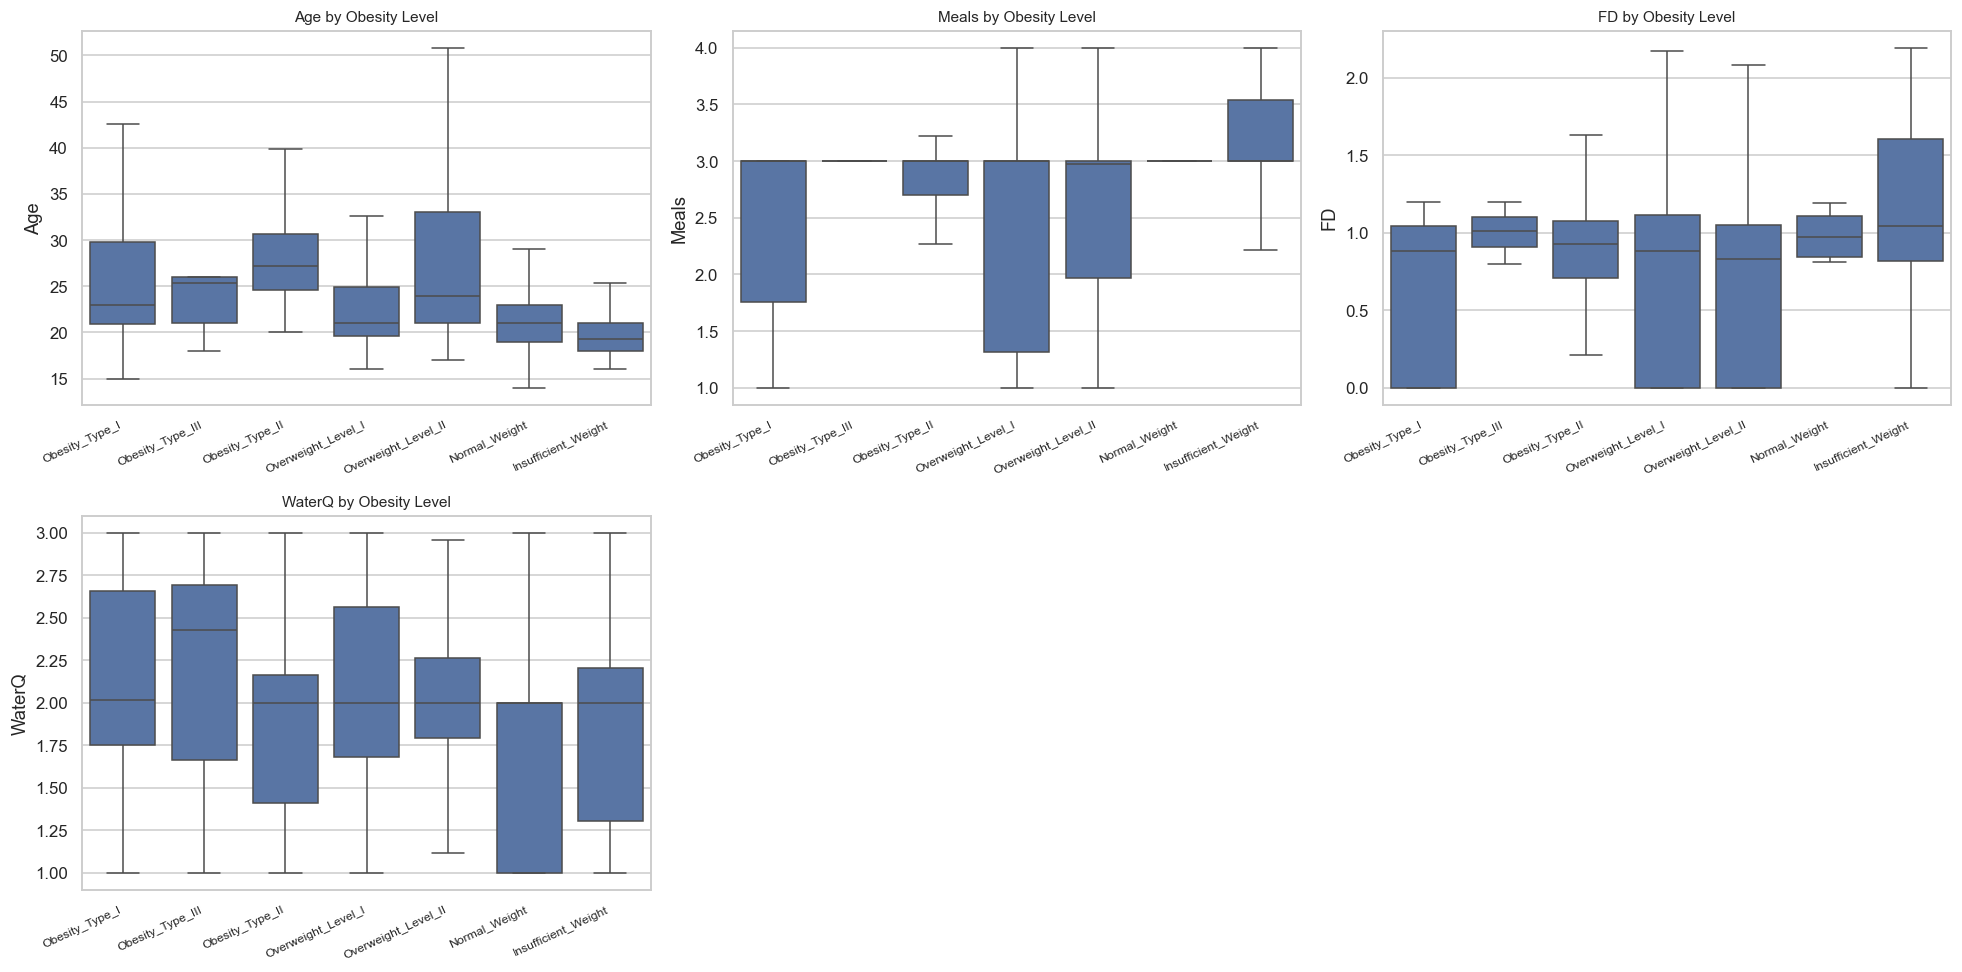

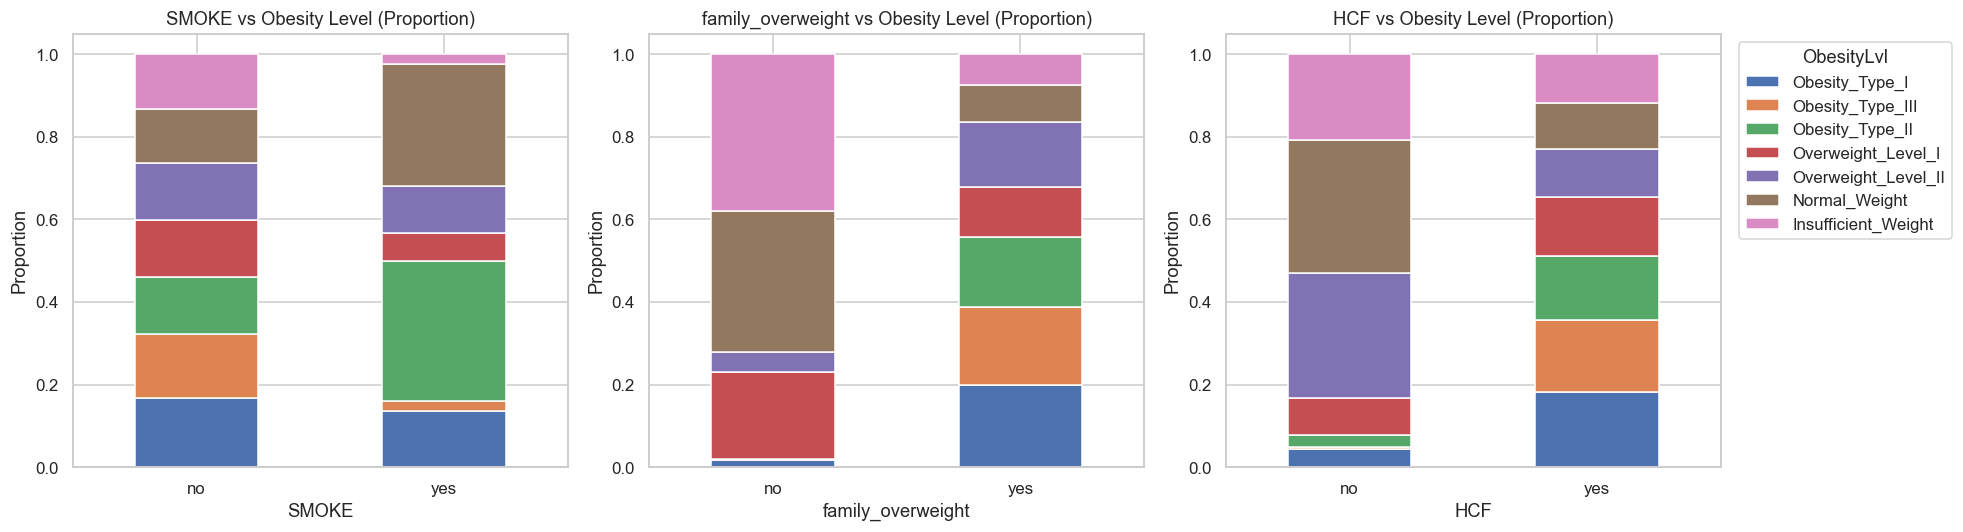

In [24]:
# Exploratory Data Analysis (EDA) — Distributions & Relationships (Robust, Fixed) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

#1) Load data
df = pd.read_csv("assignment1-dataset.csv")
df_processed = df.copy()

# 2) Column groups
target_col = "ObesityLvl"
numerical_cols = [
    "Age", "Height", "Weight", "Meals", "FD", "WaterQ",
    "PhysAct", "TechUsage", "AlcConsume"
]
binary_cols = ["family_overweight", "HCF", "VegMeals", "MealsBetw", "SMOKE", "CaloriesMonitor"]
nominal_cols = ["Gender", "TransMeans"]

# 3) Light preprocessing (for correlation only)
# (a) Encode target (optional analytics)
le = LabelEncoder()
df_processed[target_col + "_Encoded"] = le.fit_transform(df_processed[target_col].astype(str))

# (b) Map binary yes/no (case-insensitive)
binary_map = {"yes": 1, "no": 0}
for c in binary_cols:
    if c in df_processed.columns:
        df_processed[c] = df_processed[c].astype(str).str.lower().map(binary_map)

# (c) One-hot encode nominal
for c in nominal_cols:
    if c in df_processed.columns:
        df_processed = pd.get_dummies(df_processed, columns=[c], drop_first=True)

# (d) SAFE scaling for numeric features — per-column to avoid shape/key errors
scale_candidates = [c for c in numerical_cols if c in df_processed.columns]

# coerce each candidate to numeric first (non-numeric -> NaN)
for c in scale_candidates:
    df_processed[c] = pd.to_numeric(df_processed[c], errors="coerce")

# impute+scale each column independently
for c in scale_candidates:
    col = df_processed[[c]].values  # (n,1)
    if np.isnan(col).all():
        # if entirely NaN, fill with 0 and skip scaling
        df_processed[c] = 0.0
        continue
    col_imputed = SimpleImputer(strategy="median").fit_transform(col)          # (n,1)
    col_scaled  = StandardScaler(with_mean=True, with_std=True).fit_transform(col_imputed)  # (n,1)
    df_processed[c] = col_scaled.ravel()  # back to (n,)

# 4) Figure settings 
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

#  5) Histograms (raw df)
df.hist(figsize=(12, 10), bins=15)
plt.suptitle("Numeric Feature Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("EDA_01_Histograms.png")
plt.show()

# 6) Obesity level counts
plt.figure(figsize=(8, 4.5))
order_levels = df[target_col].value_counts().index
sns.countplot(data=df, x=target_col, order=order_levels)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Obesity Levels")
plt.xlabel("Obesity Level"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig("EDA_02_Obesity_Counts.png")
plt.show()

#  7) Gender vs Obesity level 
plt.figure(figsize=(8, 4.5))
if "Gender" in df.columns:
    sns.countplot(data=df, x="Gender", hue=target_col, hue_order=order_levels)
    plt.title("Gender vs Obesity Level")
    plt.xlabel("Gender"); plt.ylabel("Count")
    plt.legend(title=target_col, bbox_to_anchor=(1.02, 1), loc="upper left")
else:
    plt.text(0.5, 0.5, "Gender column not found", ha="center", va="center")
plt.tight_layout()
plt.savefig("EDA_03_Gender_vs_Obesity.png")
plt.show()

# 8) Correlation heatmap (processed)
corr_cols = [c for c in df_processed.columns if c != target_col and df_processed[c].dtype != "object"]
if corr_cols:
    corr_mat = df_processed[corr_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_mat, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title("Correlation Matrix of Encoded & Scaled Features")
    plt.tight_layout()
    plt.savefig("EDA_04_Heatmap_All_Features.png")
    plt.show()
else:
    print("No numeric columns available for correlation heatmap after preprocessing.")

# 9) Boxplots — use RAW df for interpretable units
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x=target_col, y="Height", order=order_levels, showfliers=False)
plt.title("Height by Obesity Level")
plt.xlabel("Obesity Level"); plt.ylabel("Height")
plt.xticks(rotation=25, ha="right")

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x=target_col, y="Weight", order=order_levels, showfliers=False)
plt.title("Weight by Obesity Level")
plt.xlabel("Obesity Level"); plt.ylabel("Weight")
plt.xticks(rotation=25, ha="right")

plt.tight_layout()
plt.savefig("EDA_05_Boxplots_Height_Weight.png")
plt.show()

# 10) Optional extra boxplots
extra_numeric = [c for c in ["Age", "Meals", "FD", "WaterQ"] if c in df.columns]
if extra_numeric:
    rows = int(np.ceil(len(extra_numeric)/3))
    plt.figure(figsize=(18, 4.5*rows))
    for i, col in enumerate(extra_numeric, start=1):
        plt.subplot(rows, 3, i)
        sns.boxplot(data=df, x=target_col, y=col, order=order_levels, showfliers=False)
        plt.title(f"{col} by Obesity Level", fontsize=10)
        plt.xlabel(""); plt.ylabel(col)
        plt.xticks(rotation=25, ha="right", fontsize=8)
    plt.tight_layout()
    plt.savefig("EDA_06_Boxplots_AdditionalNumerics.png")
    plt.show()

# 11) Stacked bar charts (categoricals) 
cat_for_plot = [c for c in ["SMOKE", "family_overweight", "HCF"] if c in df.columns]
if cat_for_plot:
    plt.figure(figsize=(18, 5))
    for i, col in enumerate(cat_for_plot, start=1):
        plt.subplot(1, len(cat_for_plot), i)
        ctab = pd.crosstab(df[col], df[target_col], normalize="index").reindex(columns=order_levels)
        ctab.plot(kind="bar", stacked=True, ax=plt.gca(), legend=False)
        plt.title(f"{col} vs Obesity Level (Proportion)")
        plt.xlabel(col); plt.ylabel("Proportion")
        plt.xticks(rotation=0)
    plt.legend(title=target_col, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("EDA_07_StackedBars_Categoricals.png")
    plt.show()


In [25]:
#Pre-processing Data - Converting categorical columns to numeric(encoding)+Scaling numeric columns
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Label encode categorical columns
encoder = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = encoder.fit_transform(df[col])

# Scale numeric features
scaler = StandardScaler()
num_cols = df.select_dtypes(include="number").columns
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()


,Gender,Age,Height,Weight,family_overweight,HCF,VegMeals,Meals,FD,MealsBetw,SMOKE,WaterQ,CaloriesMonitor,PhysAct,TechUsage,AlcConsume,TransMeans,ObesityLvl
0,-1.011914,-0.507743,-0.842133,-0.726275,0.472291,-2.759769,-0.785019,0.404153,-0.003712,0.300346,-0.145900,-0.013073,-0.218272,-1.188039,0.561997,1.419172,0.503337,-1.032796
1,-1.011914,-0.507743,-1.864842,-0.979330,0.472291,-2.759769,1.088342,0.404153,0.433173,0.300346,6.853997,1.618759,4.581439,2.339750,-1.080625,-0.521160,0.503337,-1.032796
2,0.988227,-0.205000,0.998743,-0.315060,0.472291,-2.759769,-0.785019,0.404153,0.248958,0.300346,-0.145900,-0.013073,-0.218272,1.163820,0.561997,-2.461491,0.503337,-1.032796
3,0.988227,0.400486,0.998743,0.001259,-2.117337,-2.759769,1.088342,0.404153,0.144385,0.300346,-0.145900,-0.013073,-0.218272,1.163820,-1.080625,-2.461491,1.296280,1.016776
4,0.988227,-0.356372,0.794201,0.089828,-2.117337,-2.759769,-0.785019,-2.167023,-1.632282,0.300346,-0.145900,-0.013073,-0.218272,-1.188039,-1.080625,-0.521160,0.503337,1.529168


In [26]:
# --- Split data into features (X) and target (y) ---
from sklearn.model_selection import train_test_split
import pandas as pd

# Ensure the target is categorical (not scaled)
df["ObesityLvl"] = df["ObesityLvl"].astype(str)

# Separate features (X) and target (y)
X = df.drop("ObesityLvl", axis=1)
y = df["ObesityLvl"]

# Step 1: Split into Train (70%) and Temp (30%) 
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 2: Split Temp into Validation (20%) and Test (10%) 
# 0.33 of 30% ≈ 10% of total data
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp
)

print(" Data Split Done (70-20-10)")
print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")


 Data Split Done (70-20-10)
Train size: (1477, 17)
Validation size: (424, 17)
Test size: (210, 17)


---

# 2. **Model Training**

Here, you need to:

1.	select and compare at least three machine learning models (seen/discussed during the lectures) appropriate for your modelling;
2.	if there are hyperparameters in a selected algorithm, define a hyperparameter search protocol (you can define your own), and tune them.


 Random Forest — 5-fold Stratified CV on Train
Macro-F1: 0.9420 ± 0.0120
Accuracy: 0.9431 ± 0.0124

 Random Forest — Test Set
Accuracy        : 0.9333
Macro-F1        : 0.9330
Balanced Acc    : 0.9323

Classification Report:
                        precision    recall  f1-score   support

-0.008009930054028188       1.00      0.97      0.98        29
  -0.5204027283586746       0.92      0.97      0.94        35
   -1.032795526663321       0.81      0.86      0.83        29
  -1.5451883249679677       0.96      1.00      0.98        27
   0.5043828682506183       1.00      0.97      0.98        32
   1.0167756665552647       0.93      0.90      0.91        29
   1.5291684648599113       0.93      0.86      0.89        29

             accuracy                           0.93       210
            macro avg       0.93      0.93      0.93       210
         weighted avg       0.94      0.93      0.93       210



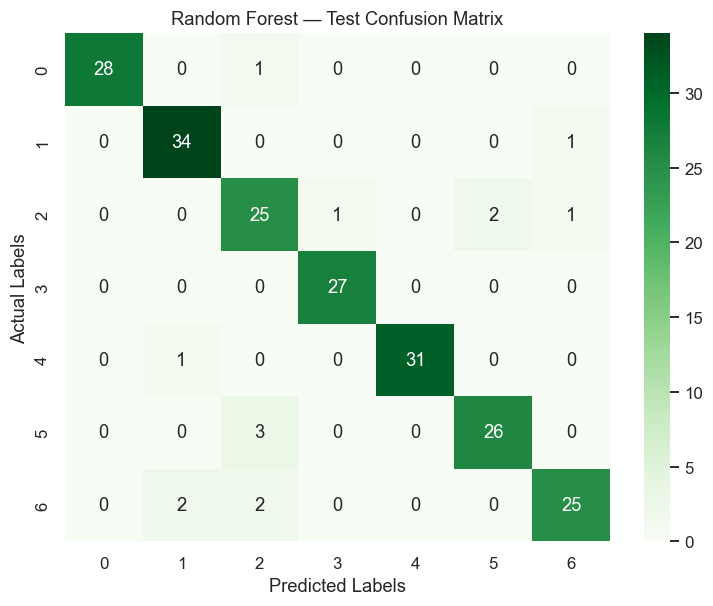

In [27]:
#Method 1 — Random Forest - eith base Hyperparameter values

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix

# 0) Build a preprocesser if you don't already have one
try:
    preprocess  # will raise NameError if not defined earlier
except NameError:
    # infer column types from X_train
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ],
        remainder="drop"
    )

# 1) Define the pipeline (preprocessing + model)
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        criterion="entropy",
        random_state=42,
        class_weight="balanced"
    ))
])

# 2) 5-fold Stratified CV on the TRAIN set only (robust baseline)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1  = cross_val_score(rf_pipe, X_train, y_train, cv=skf, scoring="f1_macro", n_jobs=-1)
cv_acc = cross_val_score(rf_pipe, X_train, y_train, cv=skf, scoring="accuracy", n_jobs=-1)

print(" Random Forest — 5-fold Stratified CV on Train")
print(f"Macro-F1: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"Accuracy: {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")

# 3) Fit on TRAIN and evaluate on TEST (keep original flow)
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

# 4) Test metrics
acc  = accuracy_score(y_test, y_pred_rf)
f1m  = f1_score(y_test, y_pred_rf, average="macro")
bacc = balanced_accuracy_score(y_test, y_pred_rf)

print("\n Random Forest — Test Set")
print(f"Accuracy        : {acc:.4f}")
print(f"Macro-F1        : {f1m:.4f}")
print(f"Balanced Acc    : {bacc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# 5) Confusion Matrix (Test)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest — Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


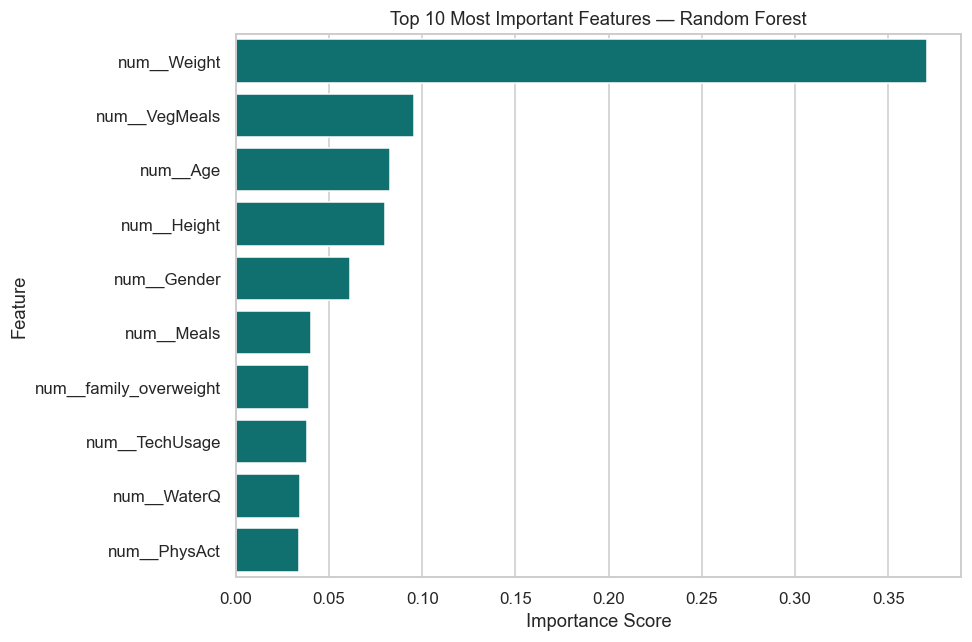


Top 10 Features:
 num__Weight               0.3707
num__VegMeals             0.0958
num__Age                  0.0826
num__Height               0.0800
num__Gender               0.0612
num__Meals                0.0406
num__family_overweight    0.0391
num__TechUsage            0.0385
num__WaterQ               0.0344
num__PhysAct              0.0338


In [28]:
# Feature Importance (works with preprocessing pipeline)

# Retrieve preprocessing and classifier from the pipeline
prep = rf_pipe.named_steps["prep"]     # ColumnTransformer
rf = rf_pipe.named_steps["clf"]        # RandomForestClassifier

# Get feature names from the preprocessor
feature_names = prep.get_feature_names_out()  # handles num__ and cat__ prefixes

# Create Series of importances with proper names
importances = pd.Series(rf.feature_importances_, index=feature_names)

# Select top 10
top_features = importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(9,6))
sns.barplot(x=top_features.values, y=top_features.index, color='teal')
plt.title("Top 10 Most Important Features — Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nTop 10 Features:\n", top_features.round(4).to_string())


ARTIFICIAL NEURAL NETWORK (ANN)
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2761 - loss: 1.9065 - val_accuracy: 0.4255 - val_loss: 1.6662
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4082 - loss: 1.5796 - val_accuracy: 0.5201 - val_loss: 1.3840
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4994 - loss: 1.3515 - val_accuracy: 0.5839 - val_loss: 1.1941
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5622 - loss: 1.1869 - val_accuracy: 0.6217 - val_loss: 1.0631
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5729 - loss: 1.1173 - val_accuracy: 0.6430 - val_loss: 0.9697
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6037 - loss: 1.0149 - val_accuracy: 0.6714 - val_loss: 0.8969
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6457 - loss: 0.9611 - val_accuracy: 0.7045 - val_loss: 0.8394
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6682 - loss: 0.9048 - 

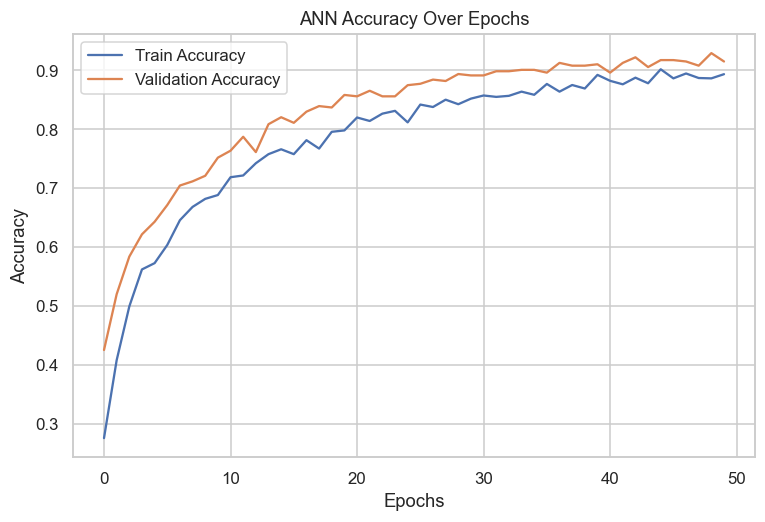

In [29]:
#Step 2 Artificial Neural Network (ANN) - with base hyperparameters

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np


print("ARTIFICIAL NEURAL NETWORK (ANN)")

# --- 1. Prepare data ---
X = df.drop("ObesityLvl", axis=1)
y = df["ObesityLvl"]

# Encode target labels to numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode output (since it's multi-class)
y_categorical = to_categorical(y_encoded)

# Scale input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pd.get_dummies(X, drop_first=True))

# 2. Split into Train and Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# 3. Build ANN Model 
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')  # output layer
])

# 4. Compile Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# 6. Evaluate Model
loss, acc = model.evaluate(X_test, y_test)
print(f"\n ANN Test Accuracy: {acc:.3f}")
print(f"Loss: {loss:.3f}")

# 7. Plot Training Progress
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [30]:
#SVM starts here- base hyperparameter
# Ensure X_train, X_val, X_test are DataFrames, not NumPy arrays
import pandas as pd

# Define column names using df ( original dataset)
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=df.drop(columns=["ObesityLvl"]).columns)
    X_val   = pd.DataFrame(X_val,   columns=df.drop(columns=["ObesityLvl"]).columns)
    X_test  = pd.DataFrame(X_test,  columns=df.drop(columns=["ObesityLvl"]).columns)

print(" Converted arrays back to DataFrames for preprocessing.")


 Converted arrays back to DataFrames for preprocessing.


 Tuning SVM with 5-fold Stratified CV...

Best Parameters: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Best CV Macro-F1: 0.9503

=== Validation Set ===
Accuracy     : 0.9575
Macro-F1     : 0.9567
Balanced Acc : 0.9572


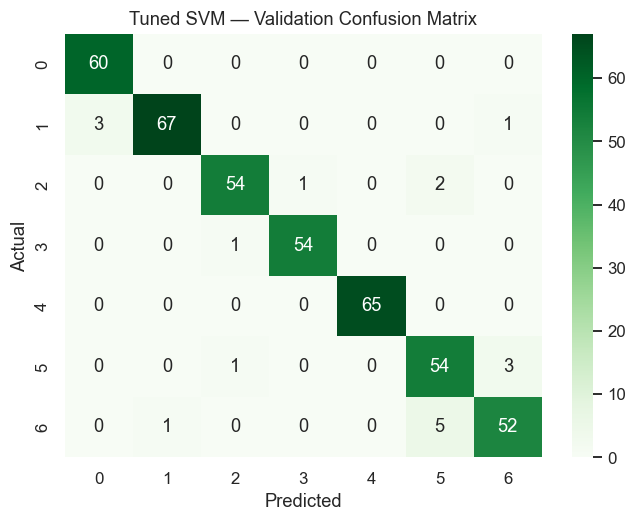


=== Test Set (Final) ===
Accuracy     : 0.9476
Macro-F1     : 0.9468
Balanced Acc : 0.9463

Classification Report:
                        precision    recall  f1-score   support

-0.008009930054028188       0.96      0.93      0.95        29
  -0.5204027283586746       0.95      1.00      0.97        35
   -1.032795526663321       0.87      0.93      0.90        29
  -1.5451883249679677       0.96      1.00      0.98        27
   0.5043828682506183       0.97      0.97      0.97        32
   1.0167756665552647       0.93      0.86      0.89        29
   1.5291684648599113       1.00      0.93      0.96        29

             accuracy                           0.95       210
            macro avg       0.95      0.95      0.95       210
         weighted avg       0.95      0.95      0.95       210



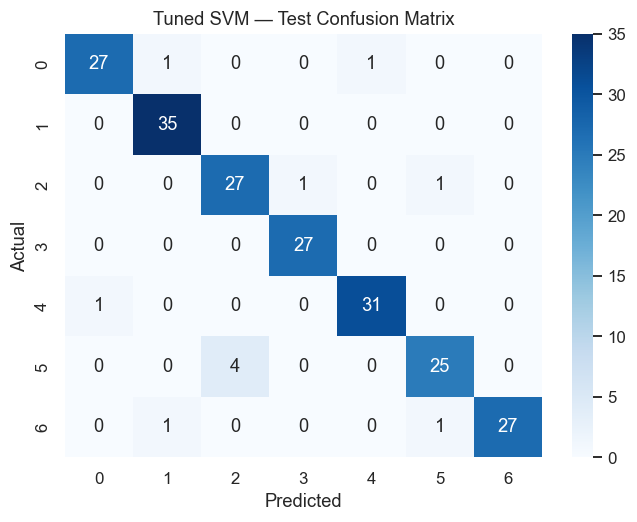

In [31]:
#Step 3 Support Vector Machine (SVM) 

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

# 1) Recreate splits from the original DataFrame so y is 1-D labels
TARGET = "ObesityLvl"
assert "df" in globals(), "Load your dataset into variable `df` first."

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(str)             

# 70/20/10 split with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)

# 2) Preprocessor (handle cat + num)
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

# OneHotEncoder arg compatibility across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", ohe, cat_cols)
])

# 3) SVM pipeline + tuning grid
svm_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", SVC(probability=True, random_state=42))
])

param_grid = {
    "clf__C": [0.1, 1, 10, 50],
    "clf__kernel": ["linear", "rbf", "poly"],
    "clf__gamma": ["scale", "auto", 0.01, 0.1, 1],
    "clf__class_weight": ["balanced"]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_svm = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=skf,
    n_jobs=-1,
    refit=True
)

print(" Tuning SVM with 5-fold Stratified CV...")
grid_svm.fit(X_train, y_train)                         # <-- y is 1-D labels now

print("\nBest Parameters:", grid_svm.best_params_)
print("Best CV Macro-F1:", round(grid_svm.best_score_, 4))

# 4) Validation evaluation
best_svm = grid_svm.best_estimator_
y_val_pred = best_svm.predict(X_val)

print("\n=== Validation Set ===")
print("Accuracy     :", round(accuracy_score(y_val, y_val_pred), 4))
print("Macro-F1     :", round(f1_score(y_val, y_val_pred, average='macro'), 4))
print("Balanced Acc :", round(balanced_accuracy_score(y_val, y_val_pred), 4))

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Tuned SVM — Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# 5) Final test evaluation (refit on Train+Val)
best_svm.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
y_test_pred = best_svm.predict(X_test)

print("\n=== Test Set (Final) ===")
print("Accuracy     :", round(accuracy_score(y_test, y_test_pred), 4))
print("Macro-F1     :", round(f1_score(y_test, y_test_pred, average='macro'), 4))
print("Balanced Acc :", round(balanced_accuracy_score(y_test, y_test_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Tuned SVM — Test Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()


---

# 3.1 **Evaluate model - Random Forest**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the appropriate set


Splits -> Train: 1477, Val: 424, Test: 210
 Tuning Random Forest (n_estimators, max_features, max_depth) with 5-fold Stratified CV...

=== Grid Search Result ===
Best params: {'clf__max_depth': 15, 'clf__max_features': 0.5, 'clf__n_estimators': 900}
Best CV Macro-F1: 0.9535

=== Validation Set ===
Accuracy     : 0.9623
Macro-F1     : 0.9612
Balanced Acc : 0.9606


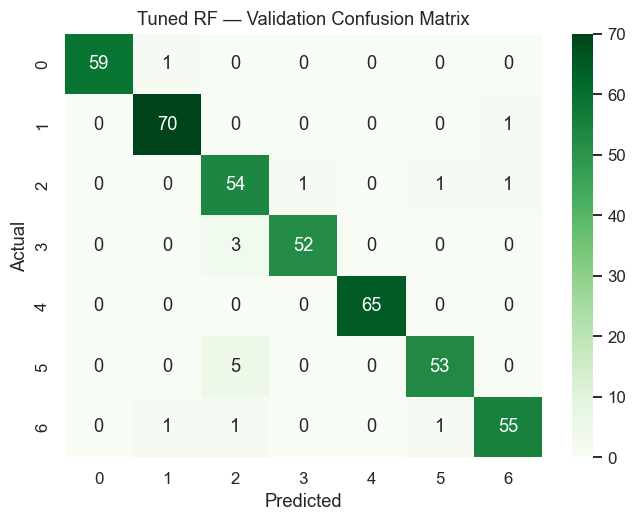


=== Test Set (Final) ===
Accuracy     : 0.9571
Macro-F1     : 0.9567
Balanced Acc : 0.9570

Classification report:
                        precision    recall  f1-score   support

-0.008009930054028188       0.97      0.97      0.97        29
  -0.5204027283586746       0.97      0.97      0.97        35
   -1.032795526663321       0.90      0.90      0.90        29
  -1.5451883249679677       1.00      1.00      1.00        27
   0.5043828682506183       1.00      0.97      0.98        32
   1.0167756665552647       0.93      0.90      0.91        29
   1.5291684648599113       0.94      1.00      0.97        29

             accuracy                           0.96       210
            macro avg       0.96      0.96      0.96       210
         weighted avg       0.96      0.96      0.96       210



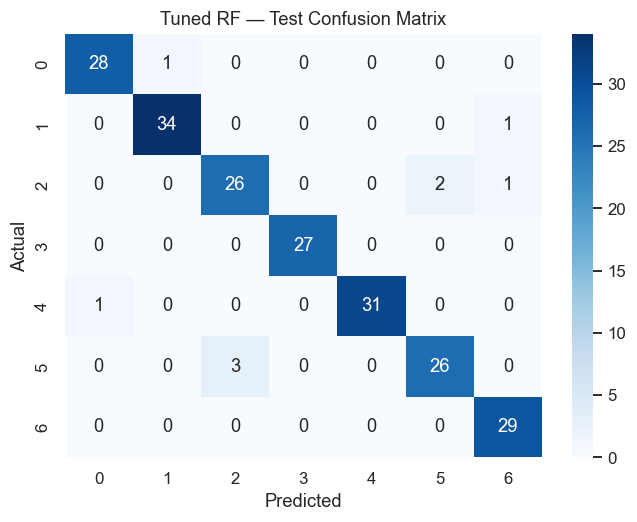

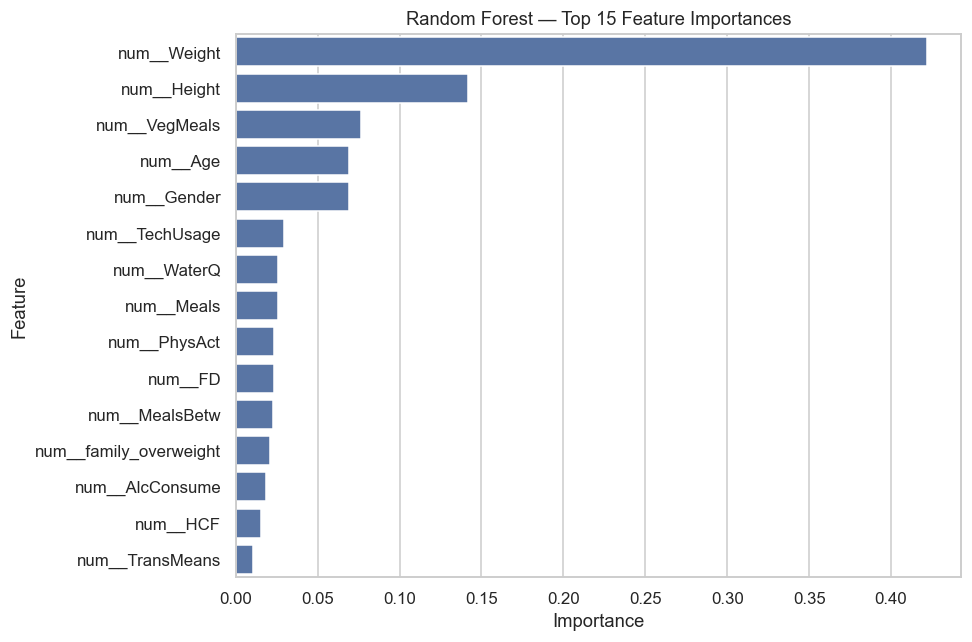

In [32]:
# Random Forest (focused tuning on n_estimators, max_features, max_depth) — resilient version
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

# 0) Ensure df and consistent splits
TARGET = "ObesityLvl"
assert "df" in globals(), "DataFrame 'df' not found. Load your dataset into variable df."

need_resplit = not all(k in globals() for k in ["X_train", "X_val", "X_test", "y_train", "y_val", "y_test"])
if need_resplit:
    X = df.drop(columns=[TARGET])
    y = df[TARGET].astype(str)
    # 70/20/10 split with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42
    )

print(f"Splits -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

#  1) Preprocessor with sklearn compatibility 
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

# Handle OneHotEncoder arg differences across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    # Older scikit-learn
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

#2) RF pipeline + focused grid 
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        bootstrap=True
    ))
])

param_grid = {
    "clf__n_estimators": [300, 600, 900, 1200],
    "clf__max_features": ["sqrt", "log2", 0.5],   # float supported in newer sklearn; kept for performance exploration
    "clf__max_depth": [None, 15, 25, 35],
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=skf,
    n_jobs=-1,
    refit=True,
    verbose=0
)

print(" Tuning Random Forest (n_estimators, max_features, max_depth) with 5-fold Stratified CV...")
gs.fit(X_train, y_train)

#3) Validation evaluation 
best_model = gs.best_estimator_
y_val_pred = best_model.predict(X_val)

print("\n=== Grid Search Result ===")
print("Best params:", gs.best_params_)
print("Best CV Macro-F1:", round(gs.best_score_, 4))

val_acc  = accuracy_score(y_val, y_val_pred)
val_f1m  = f1_score(y_val, y_val_pred, average="macro")
val_bacc = balanced_accuracy_score(y_val, y_val_pred)
print("\n=== Validation Set ===")
print(f"Accuracy     : {val_acc:.4f}")
print(f"Macro-F1     : {val_f1m:.4f}")
print(f"Balanced Acc : {val_bacc:.4f}")

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Tuned RF — Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# ---------------- 4) Final test (refit on Train+Val) ----------------
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_trval, y_trval)

y_test_pred = best_model.predict(X_test)

print("\n=== Test Set (Final) ===")
test_acc  = accuracy_score(y_test, y_test_pred)
test_f1m  = f1_score(y_test, y_test_pred, average="macro")
test_bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f"Accuracy     : {test_acc:.4f}")
print(f"Macro-F1     : {test_f1m:.4f}")
print(f"Balanced Acc : {test_bacc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_test_pred))

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Tuned RF — Test Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# 5) Feature importances (robust to sklearn version) 
prep = best_model.named_steps["prep"]
rf   = best_model.named_steps["clf"]

try:
    feat_names = prep.get_feature_names_out()  # newer sklearn
except Exception:
    # Fallback: manually compose names
    num_names = [f"num__{c}" for c in num_cols]
    # Get OHE categories to expand categorical names
    cat_cat = prep.named_transformers_["cat"].categories_
    cat_names = []
    for col, cats in zip(cat_cols, cat_cat):
        cat_names += [f"cat__{col}_{c}" for c in cats]
    feat_names = np.array(num_names + cat_names)

importances = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)

top_k = 15
plt.figure(figsize=(9,6))
sns.barplot(x=importances.head(top_k).values, y=importances.head(top_k).index)
plt.title(f"Random Forest — Top {top_k} Feature Importances")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()


---

# 3.2 **Evaluate model - ANN**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the appropriate set


Label mapping: {0: '-0.008009930054028188', 1: '-0.5204027283586746', 2: '-1.032795526663321', 3: '-1.5451883249679677', 4: '0.5043828682506183', 5: '1.0167756665552647', 6: '1.5291684648599113'}

🔹 Training ANN/MLP — Baseline...
ANN/MLP Baseline (Val): Acc=0.9104 | Macro-Precision=0.9107 | Macro-F1=0.9076 | BalAcc=0.9075

Classification report (Baseline, Val):
                       precision    recall  f1-score   support

-0.008009930054028188       0.95      1.00      0.98        60
  -0.5204027283586746       0.94      0.94      0.94        71
   -1.032795526663321       0.76      0.89      0.82        57
  -1.5451883249679677       1.00      0.95      0.97        55
   0.5043828682506183       0.98      1.00      0.99        65
   1.0167756665552647       0.85      0.76      0.80        58
   1.5291684648599113       0.89      0.81      0.85        58

             accuracy                           0.91       424
            macro avg       0.91      0.91      0.91       424
    

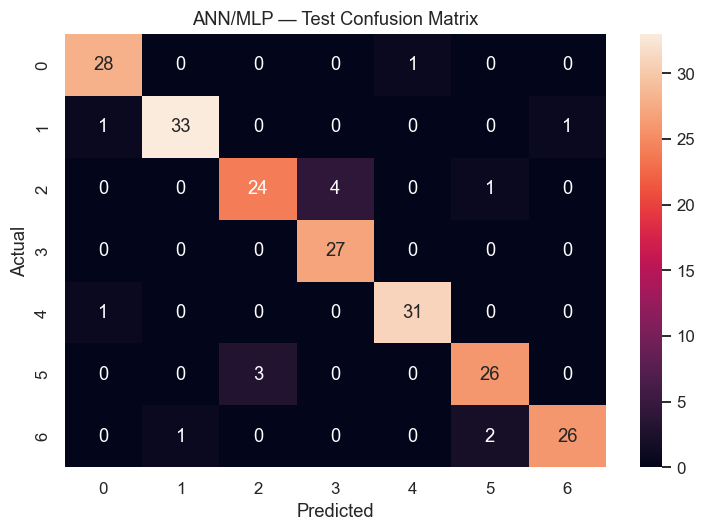

In [33]:
# === ANN / MLP — Baseline vs Tuned (robust, end-to-end) ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

#  0) Data & target 
assert "df" in globals(), "Please load your cleaned dataset into a DataFrame named `df`."
TARGET = "ObesityLvl"

# Drop fully-empty columns (safety)
df = df.dropna(axis=1, how="all").copy()

# Convert non-numeric columns to string (so OHE handles them)
for c in df.columns:
    if c != TARGET and (df[c].dtype == "object" or not np.issubdtype(df[c].dtype, np.number)):
        df[c] = df[c].astype(str)

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(str)          # 1-D string labels

#  1) Train/Val/Test splits (70/20/10) 
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_va, X_te, y_va, y_te   = train_test_split(X_tmp, y_tmp, test_size=0.33, stratify=y_tmp, random_state=42)

#2) Robust preprocessing 
cat_cols = X_tr.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_tr.select_dtypes(include=[np.number]).columns.tolist()

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler(with_mean=True, with_std=True))
])

# OneHotEncoder API changed across versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe",    ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# Force numeric float output to MLP (avoids dtype/object issues)
to_float = FunctionTransformer(lambda A: np.asarray(A, dtype=np.float64))

# 3) Encode y to integers (prevents np.isnan crash in scoring)
le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
y_va_enc = le.transform(y_va)
y_te_enc = le.transform(y_te)
print("Label mapping:", dict(enumerate(le.classes_)))

def metrics_block(name, y_true_enc, y_pred_enc):
    acc  = accuracy_score(y_true_enc, y_pred_enc)
    prec = precision_score(y_true_enc, y_pred_enc, average="macro", zero_division=0)
    f1m  = f1_score(y_true_enc, y_pred_enc, average="macro")
    bacc = balanced_accuracy_score(y_true_enc, y_pred_enc)
    print(f"{name}: Acc={acc:.4f} | Macro-Precision={prec:.4f} | Macro-F1={f1m:.4f} | BalAcc={bacc:.4f}")
    return acc, prec, f1m, bacc

#  4) Baseline MLP (defaults) 
mlp_base = Pipeline([
    ("prep", preprocess),
    ("tofloat", to_float),
    ("clf",  MLPClassifier(random_state=42))  # defaults: hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=1e-4, lr=1e-3, max_iter=200
])

print("\n🔹 Training ANN/MLP — Baseline...")
mlp_base.fit(X_tr, y_tr_enc)
y_va_pred_base_enc = mlp_base.predict(X_va)
metrics_block("ANN/MLP Baseline (Val)", y_va_enc, y_va_pred_base_enc)

# (Optional) human-readable report on validation
print("\nClassification report (Baseline, Val):")
print(classification_report(y_va_enc, y_va_pred_base_enc, target_names=le.classes_))

# 5) Tuned MLP (GridSearchCV with Stratified 5-fold)\
mlp_tuned = Pipeline([
    ("prep", preprocess),
    ("tofloat", to_float),
    ("clf",  MLPClassifier(random_state=42, early_stopping=True, n_iter_no_change=10))
])

param_grid_mlp = {
    "clf__hidden_layer_sizes": [(128,), (128, 64), (256, 128)],
    "clf__activation": ["relu", "tanh"],
    "clf__alpha": [1e-4, 1e-3, 1e-2],             # L2 regularisation
    "clf__learning_rate_init": [1e-3, 5e-3, 1e-2],
    "clf__batch_size": [64, 128],
    "clf__max_iter": [250, 400]                   # allow convergence
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_mlp = GridSearchCV(
    estimator=mlp_tuned,
    param_grid=param_grid_mlp,
    scoring="f1_macro",
    cv=skf,
    n_jobs=-1,
    refit=True
)

print("\n🔍 Tuning ANN/MLP with 5-fold Stratified CV...")
gs_mlp.fit(X_tr, y_tr_enc)
print(" Best params:", gs_mlp.best_params_)
best_mlp = gs_mlp.best_estimator_

# Validation eval (encoded ints)
y_va_pred_tuned_enc = best_mlp.predict(X_va)
metrics_block("ANN/MLP Tuned (Val)", y_va_enc, y_va_pred_tuned_enc)

print("\nClassification report (Tuned, Val):")
print(classification_report(y_va_enc, y_va_pred_tuned_enc, target_names=le.classes_))

# 6) Final Test (retrain on Train+Val) 
X_trva  = pd.concat([X_tr, X_va], axis=0)
y_trva_enc = np.concatenate([y_tr_enc, y_va_enc], axis=0)

print("\n Retraining best ANN/MLP on Train+Val and evaluating on Test...")
best_mlp.fit(X_trva, y_trva_enc)
y_te_pred_enc = best_mlp.predict(X_te)
metrics_block("ANN/MLP Tuned (Test)", y_te_enc, y_te_pred_enc)

print("\nClassification report (Tuned, Test):")
print(classification_report(y_te_enc, y_te_pred_enc, target_names=le.classes_))

# (Optional) Confusion matrix on Test
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_te_enc, y_te_pred_enc), annot=True, fmt="d")
plt.title("ANN/MLP — Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


---

# 3.3 **Evaluate model- SVM**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the appropriate set


Label mapping: {0: '-0.008009930054028188', 1: '-0.5204027283586746', 2: '-1.032795526663321', 3: '-1.5451883249679677', 4: '0.5043828682506183', 5: '1.0167756665552647', 6: '1.5291684648599113'}

🔹 Training SVM — Baseline (Default Parameters)...
SVM Baseline (Val): Acc=0.8632 | Macro-Precision=0.8658 | Macro-F1=0.8605 | BalAcc=0.8592

Classification Report (Baseline, Val):
                       precision    recall  f1-score   support

-0.008009930054028188       0.92      1.00      0.96        60
  -0.5204027283586746       0.89      0.89      0.89        71
   -1.032795526663321       0.65      0.77      0.70        57
  -1.5451883249679677       0.98      0.87      0.92        55
   0.5043828682506183       1.00      1.00      1.00        65
   1.0167756665552647       0.80      0.76      0.78        58
   1.5291684648599113       0.82      0.72      0.77        58

             accuracy                           0.86       424
            macro avg       0.87      0.86      0.86  

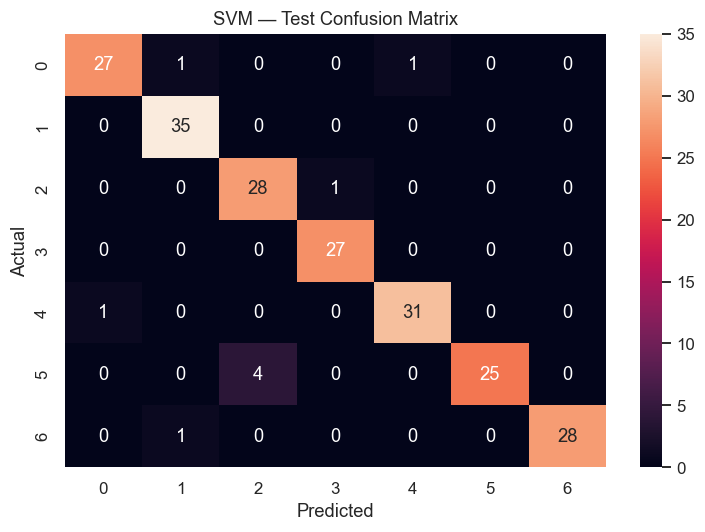

In [34]:
# Support Vector Machine (SVM) — Baseline vs Tuned
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

#  0) Base data 
assert "df" in globals(), "Please load your cleaned dataset into df first."
TARGET = "ObesityLvl"

# Drop empty columns (safety)
df = df.dropna(axis=1, how="all").copy()

# Convert all categorical/text columns to string
for c in df.columns:
    if c != TARGET and (df[c].dtype == "object" or not np.issubdtype(df[c].dtype, np.number)):
        df[c] = df[c].astype(str)

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(str)

#  1) Train/Val/Test split 
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_va, X_te, y_va, y_te   = train_test_split(X_tmp, y_tmp, test_size=0.33, stratify=y_tmp, random_state=42)

#  2) Preprocessing 
cat_cols = X_tr.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_tr.select_dtypes(include=[np.number]).columns.tolist()

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe",    ohe)
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Encode y labels into integers for safety in CV scoring
le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr)
y_va_enc = le.transform(y_va)
y_te_enc = le.transform(y_te)
print("Label mapping:", dict(enumerate(le.classes_)))

def report_metrics(name, y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    f1m  = f1_score(y_true, y_pred, average="macro")
    bacc = balanced_accuracy_score(y_true, y_pred)
    print(f"{name}: Acc={acc:.4f} | Macro-Precision={prec:.4f} | Macro-F1={f1m:.4f} | BalAcc={bacc:.4f}")
    return acc, prec, f1m, bacc

# 3) Baseline SVM (defaults) 
# Default SVC() hyperparameters:
# C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True,
# probability=False, tol=1e-3, cache_size=200, class_weight=None

svm_base = Pipeline([
    ("prep", preprocess),
    ("clf", SVC(random_state=42))   # all defaults
])

print("\n🔹 Training SVM — Baseline (Default Parameters)...")
svm_base.fit(X_tr, y_tr_enc)
y_va_pred_base = svm_base.predict(X_va)
report_metrics("SVM Baseline (Val)", y_va_enc, y_va_pred_base)
print("\nClassification Report (Baseline, Val):")
print(classification_report(y_va_enc, y_va_pred_base, target_names=le.classes_))

#  4) Tuned SVM (GridSearchCV) 
svm_tuned = Pipeline([
    ("prep", preprocess),
    ("clf", SVC(random_state=42, probability=True, class_weight="balanced"))
])

param_grid_svm = {
    "clf__C": [0.1, 1, 5, 10, 25],            # default is 1.0
    "clf__kernel": ["linear", "rbf", "poly"], # default is 'rbf'
    "clf__gamma": ["scale", "auto", 0.01, 0.1]# default is 'scale'
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_svm = GridSearchCV(
    estimator=svm_tuned,
    param_grid=param_grid_svm,
    scoring="f1_macro",
    cv=skf,
    n_jobs=-1,
    refit=True
)

print("\n🔍 Tuning SVM with 5-fold Stratified CV...")
gs_svm.fit(X_tr, y_tr_enc)
print(" Best parameters:", gs_svm.best_params_)

best_svm = gs_svm.best_estimator_
y_va_pred_tuned = best_svm.predict(X_va)
report_metrics("SVM Tuned (Val)", y_va_enc, y_va_pred_tuned)

print("\nClassification Report (Tuned, Val):")
print(classification_report(y_va_enc, y_va_pred_tuned, target_names=le.classes_))

#5) Final Test 
X_trva = pd.concat([X_tr, X_va], axis=0)
y_trva_enc = np.concatenate([y_tr_enc, y_va_enc], axis=0)

print("\n Retraining best SVM on Train+Val and evaluating on Test...")
best_svm.fit(X_trva, y_trva_enc)
y_te_pred = best_svm.predict(X_te)
report_metrics("SVM Tuned (Test)", y_te_enc, y_te_pred)

print("\nClassification Report (Tuned, Test):")
print(classification_report(y_te_enc, y_te_pred, target_names=le.classes_))

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_te_enc, y_te_pred), annot=True, fmt="d")
plt.title("SVM — Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
